# Arrow detection using tensorflow

## 1. Load configs

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle

files = pickle.load(open('files.pickle', 'rb'))
paths = pickle.load(open('paths.pickle', 'rb'))

## 2. Load model

In [2]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [4]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 3. Load image and detect

In [5]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
a=['IMG_20210706_091951.jpg',
'IMG_20210706_093257.jpg',
'IMG_20210713_185245.jpg',
'IMG_20210713_190716.jpg',
'IMG_20210716_184927.jpg',
'IMG_20210716_190302.jpg',
'IMG_20210706_092755.jpg',
'IMG_20210713_183005.jpg',
'IMG_20210713_190253.jpg',
'IMG_20210713_191239.jpg',
'IMG_20210716_185412.jpg',
'IMG_20210716_192912.jpg']
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', a[8])


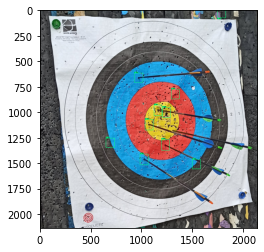

In [24]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.1,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
detections